In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, lstsq


In [3]:
from experiments import MoreTraceGases, Sensors
from experiments import utilities as utils
from bayesinverse import Regression

In [4]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/more_trace_gases/config.yaml"
)

exp = MoreTraceGases(config_path)
# basic_setup.run()


sensors 0.002930060029029846
emissions 2.568094402551651
transport 5.017796143889427


In [5]:
exp.sensors_config

{'n_sensors': 10, 'height': 0, 'noise': 1.0, 'seed': 2, 'time': 336}

In [6]:
# CO2 sensors
exp.sensors_co2 = Sensors(exp.sensors_config)

# CO sensors
co_config = exp.sensors_config
co_config["noise"] = .01
co_config["seed"] = 5
exp.sensors_co = Sensors(exp.sensors_config)

In [7]:
exp.K = exp.transport.get_transport(
    n_sensors=exp.sensors_co2.n_sensors + exp.sensors_co.n_sensors,
    sensors_index=utils.concatenate_indices(
        exp.sensors_co2.get_index(), exp.sensors_co.get_index()
    ),
    emissions=exp.emissions,
    n_processes=32
)

# Multiply with emission factor
em_factors_co = exp.emissions.get_emission_factors()[exp.emissions.mask]
em_factors = xr.DataArray(em_factors_co, dims=["source_group"])
em_factors
# sensor, time_measurement, source_group, time_state
exp.K[exp.sensors_co2.n_sensors:,] *= em_factors

loop start 35.83428147435188
loop end 35.97424317896366


In [8]:
noise = xr.concat(
    [exp.sensors_co2.get_noise(), exp.sensors_co.get_noise()], dim="sensor"
)
covariance = xr.concat(
    [exp.sensors_co2.get_covariance(), exp.sensors_co.get_covariance()], dim="sensor"
)

In [9]:
# exp.emissions.prior_covariance = utils.compute_prior_covariance(
#     xr_prior_var=exp.emissions.prior_variance,
#     tau_h=2.00,
#     tau_d=1,
# )

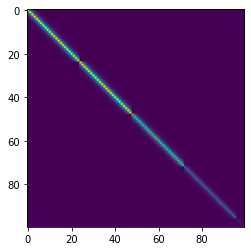

In [10]:
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:100, :100])

In [11]:
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors)) @ exp.emissions.truth
        + noise.isel(sensor=slice(exp.sensors_co2.n_sensors))
    ).values,
    K=utils.stack_xr(exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
)
x_est, res, rank, s = exp.reg.fit()
posterior = exp.emissions.to_xr(x_est)


In [12]:
exp.reg_combined = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + noise).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance).values,
)
x_est, res, rank, s = exp.reg_combined.fit()
posterior_combined = exp.emissions.to_xr(x_est)

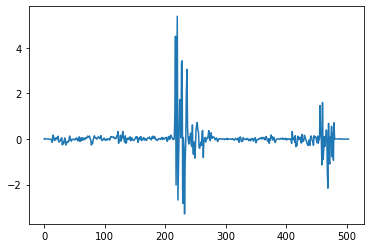

In [13]:
plt.plot(utils.stack_xr(posterior_combined - posterior))

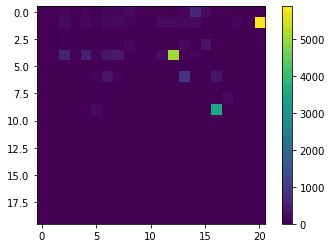

In [14]:
im = plt.imshow(exp.K.sum(dim=["time_state", "time_measurement"]))
plt.colorbar()

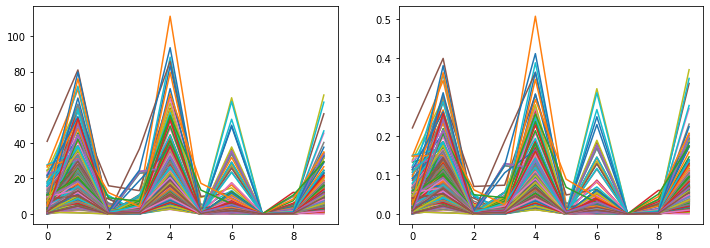

In [15]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
plt.plot((exp.K @ exp.emissions.truth)[:exp.sensors_co2.n_sensors])
plt.subplot(122)
plt.plot((exp.K @ exp.emissions.truth)[exp.sensors_co2.n_sensors:])
pass

In [16]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]
posterior = utils.unstack_xr(posterior) * true_emissions
# To xarray
posterior_covariance = exp.emissions.to_xr(exp.reg.get_posterior_covariance())
# Multiply with emissions
posterior_covariance = utils.unstack_xr(posterior_covariance) * true_emissions
posterior_covariance = posterior_covariance * true_emissions.rename(
    source_group="source_group_2"
)


In [17]:
posterior_combined = utils.unstack_xr(posterior_combined) * true_emissions
# To xarray
posterior_combined_covariance = exp.emissions.to_xr(exp.reg_combined.get_posterior_covariance())
# Multiply with emissions
posterior_combined_covariance = utils.unstack_xr(posterior_combined_covariance) * true_emissions
posterior_combined_covariance = posterior_combined_covariance * true_emissions.rename(
    source_group="source_group_2"
)


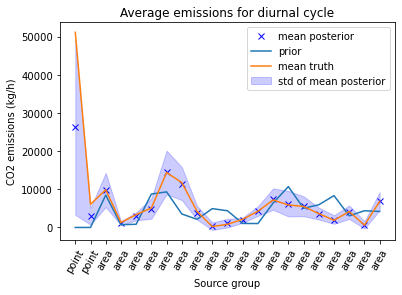

In [27]:
mean = utils.unstack_xr(posterior).mean("time_state")
std = utils.unstack_xr(posterior).std("time_state")
line = plt.plot(mean, "bx", label="mean posterior")[0]
plt.fill_between(
    range(len(mean)),
    mean - std,
    mean + std,
    alpha=0.2,
    color=line._color,
    label="std of mean posterior",
)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="mean truth")
plt.xlabel("Source group")
plt.ylabel("CO2 emissions (kg/h)")
plt.legend()
plt.xticks(np.arange(21), ["point"] * 2 + ["area"] * 19, rotation=60)
plt.title("Average emissions for diurnal cycle")
pass


In [ ]:
var = []
for coor, sub_arr in posterior_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var.append(utils.var_of_sum(cov))

In [ ]:
var_combined = []
for coor, sub_arr in posterior_combined_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var_combined.append(utils.var_of_sum(cov))

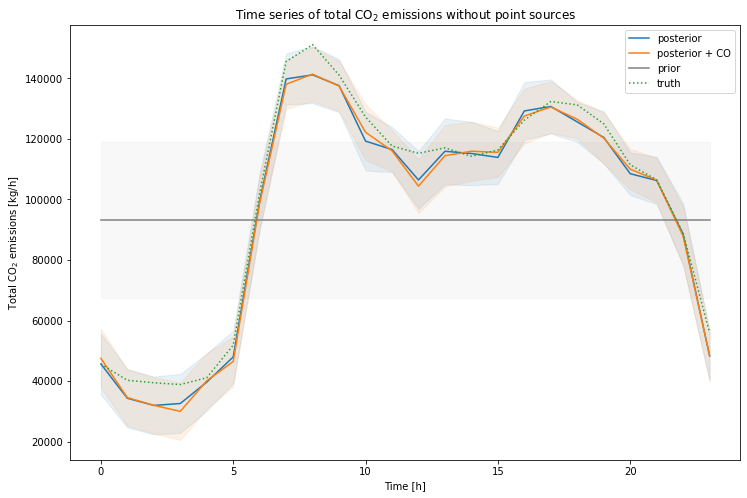

In [ ]:
plt.figure(figsize=(12, 8))
mean = posterior.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.05,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions without point sources")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig(
    "/home/rmaiwald/results/preliminary/more_trace_gases_timeseries_no_point_sources"
)


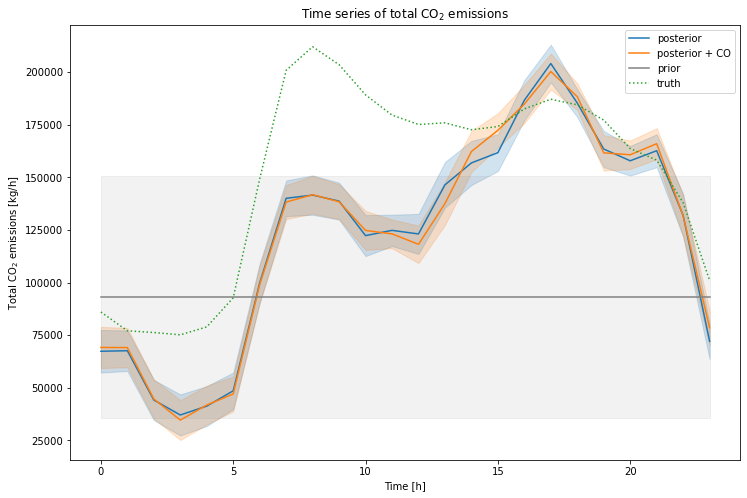

In [ ]:
plt.figure(figsize=(12, 8))
mean = posterior.sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = posterior_combined.sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.1,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

<xarray.DataArray ()>
array(2333.44169054)


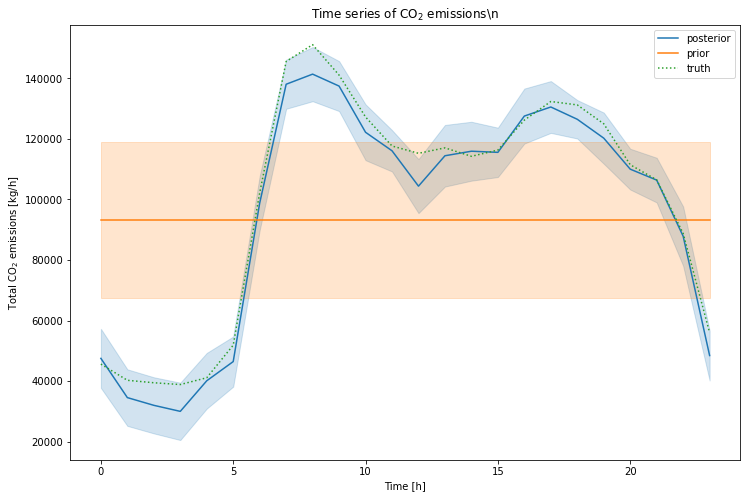

In [ ]:
plt.figure(figsize=(12, 8))
mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.2,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
print((mean - mean_prior).mean())
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

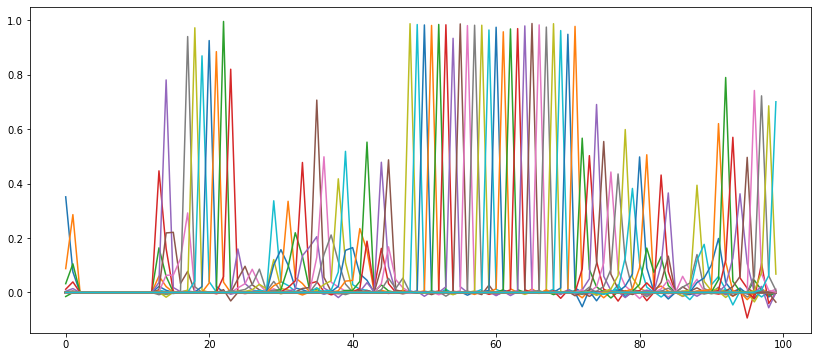

In [ ]:
plt.figure(figsize=(14, 6))
averaging_kernel = exp.reg.get_averaging_kernel()
# for i in range(averaging_kernel.shape[0]):
for i in range(100):
    kernel = averaging_kernel[i]
    plt.plot(kernel[:100], label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [ ]:
posterior

<xarray.DataArray (source_group: 21, time_state: 24)>
array([[ 2.17108887e+04,  3.32974774e+04,  1.22493980e+04,
         4.50616910e+03,  1.65736654e+03,  6.15032493e+02,
         2.51631416e+02,  1.94505995e+02,  3.80136183e+02,
         1.08454740e+03,  3.00706018e+03,  8.28916914e+03,
         1.66289810e+04,  3.04872427e+04,  4.16360088e+04,
         4.78066098e+04,  5.73506700e+04,  7.32956450e+04,
         5.96419491e+04,  4.29069495e+04,  4.93267875e+04,
         5.63568620e+04,  4.33891519e+04,  2.38016765e+04],
       [ 4.33395306e+03,  2.65006519e+03,  9.84646633e+01,
        -1.41444770e+03, -4.83119857e+02, -7.27303932e+01,
         4.19701964e+03,  2.91330239e+03,  3.18706130e+03,
         3.51459936e+03,  3.67144218e+03,  6.57542701e+03,
         6.64521058e+03,  2.69495813e+03,  4.75949558e+03,
         3.71936967e+03,  5.07944910e+03,  5.79883033e+03,
         1.76643724e+03,  8.92361707e+02,  3.24102275e+03,
         4.75307830e+03,  2.21603704e+03,  1.54578375e+01],
       [ 4.04624297e+03,  2.71218973e+03,  3.20740175e+03,
         1.62783514e+03,  3.30148742e+03,  4.29645984e+03,
         7.78489694e+03,  1.55476075e+04,  1.59337839e+04,
         1.48960122e+04,  1.20104448e+04,  1.12675135e+04,
...
         2.30020857e+03,  5.80011918e+03,  6.31863007e+03,
         4.72570315e+03,  5.55162697e+03,  6.65715784e+03,
         4.63635694e+03,  5.06144721e+03,  3.45655809e+03,
         5.60274266e+03,  4.45620350e+03,  1.79452468e+03],
       [-1.34218423e+03, -4.55807892e+02, -1.45711892e+02,
         1.08365894e+03,  9.59292090e+02,  7.28996531e+02,
         4.31787520e+02,  8.06736678e+02,  7.68403573e+02,
         8.29838240e+02, -2.75360973e+01,  1.34585741e+03,
         7.89839168e+02,  3.20014864e+03, -4.91703506e+02,
         2.17890940e+03,  2.17209873e+03,  6.99701273e+02,
         5.70395615e+02,  9.58998124e+02,  1.22131457e+03,
         4.04289270e+02,  2.61188680e+02, -7.65114872e+02],
       [ 3.50701740e+03,  3.14065787e+03,  3.03848580e+03,
         3.06285805e+03,  3.32296081e+03,  3.90102894e+03,
         7.02972920e+03,  9.63348578e+03,  1.02411624e+04,
         9.52927113e+03,  8.97235335e+03,  8.04280376e+03,
         7.86315811e+03,  7.91624151e+03,  7.66858728e+03,
         7.83444669e+03,  8.20237850e+03,  8.51758122e+03,
         8.99417757e+03,  8.71770066e+03,  7.78764765e+03,
         7.72006026e+03,  6.39571861e+03,  3.90999866e+03]])
Coordinates:
  * source_group  (source_group) int64 1 2 25 26 27 28 29 ... 41 42 43 44 45 46
  * time_state    (time_state) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23

In [ ]:
exp.emissions.prior_covariance  

<xarray.DataArray (source_group: 21, time_state: 24, time_state_2: 24,
                   source_group_2: 21)>
array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.67879441e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.35335283e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.67879441e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.67879441e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.38294055e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.75922218e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.38294055e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.08755398e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.38294055e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.75922218e-01]]]])
Coordinates:
  * source_group_2  (source_group_2) int64 1 2 25 26 27 28 ... 41 42 43 44 45 46
  * source_group    (source_group) int64 1 2 25 26 27 28 ... 41 42 43 44 45 46
Dimensions without coordinates: time_state, time_state_2

In [ ]:
averaging_kernel = exp.reg.get_averaging_kernel()
averaging_kernel = xr.DataArray(
    averaging_kernel,
    dims=["state", "state_2"],
    coords=utils.stack_xr(exp.emissions.prior_covariance).coords,
)

averaging_kernel = utils.unstack_xr(averaging_kernel)
averaging_kernel = (
    averaging_kernel
    * true_emissions
    / true_emissions.rename(source_group="source_group_2")
    # / (true_emissions**2).sum()
)
averaging_kernel = utils.stack_xr(averaging_kernel)


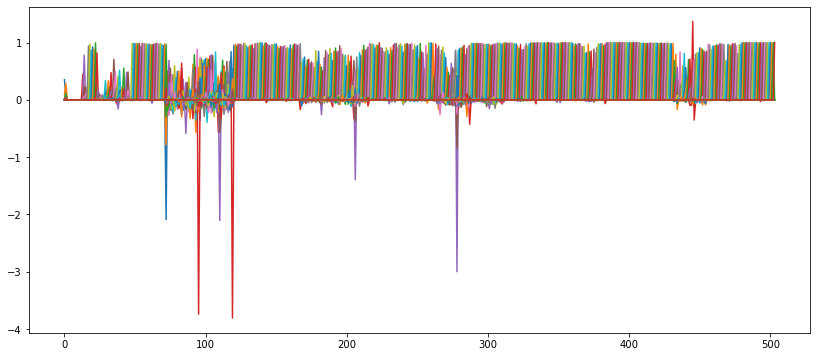

In [ ]:
plt.figure(figsize=(14, 6))
# for i in range(averaging_kernel.shape[0]):
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [ ]:
for i in range(len(averaging_kernel["time_state"])):
    kernel = averaging_kernel.isel(time_state=i, time_state_2=i)
    plt.plot(kernel, label=kernel.sum())


ValueError: Dimensions {'time_state', 'time_state_2'} do not exist. Expected one or more of ('state', 'state_2')

0


TypeError: Invalid shape (21, 100, 21, 100) for image data

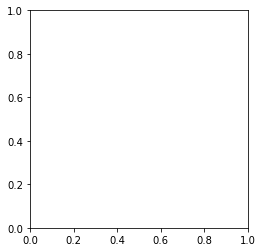

In [ ]:
print(np.where(averaging_kernel > 1., 1, 0).sum())
plt.imshow(np.where(averaging_kernel > 1., 1, 0))

In [ ]:
l = cholesky(np.diag(utils.stack_xr(exp.emissions.prior_covariance).values))
im = plt.imshow(l)
plt.colorbar(im)

ValueError: Input array is expected to be square but has the shape: (1, 2100).

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).min()

-14212215641.29782

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).max()

3892855502.133504

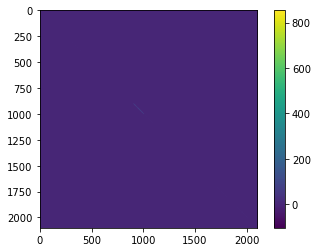

In [ ]:
im = plt.imshow(
    exp.reg.get_posterior_covariance()
)
plt.colorbar(im)


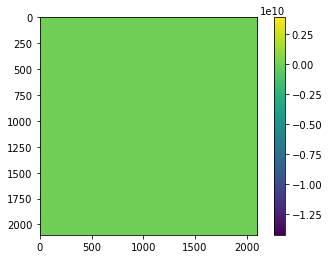

In [ ]:
im = plt.imshow(
    utils.stack_xr(exp.emissions.truth_absolute).values
    * exp.reg.get_posterior_covariance()
    * utils.stack_xr(exp.emissions.truth_absolute).values.T
)
plt.colorbar(im)


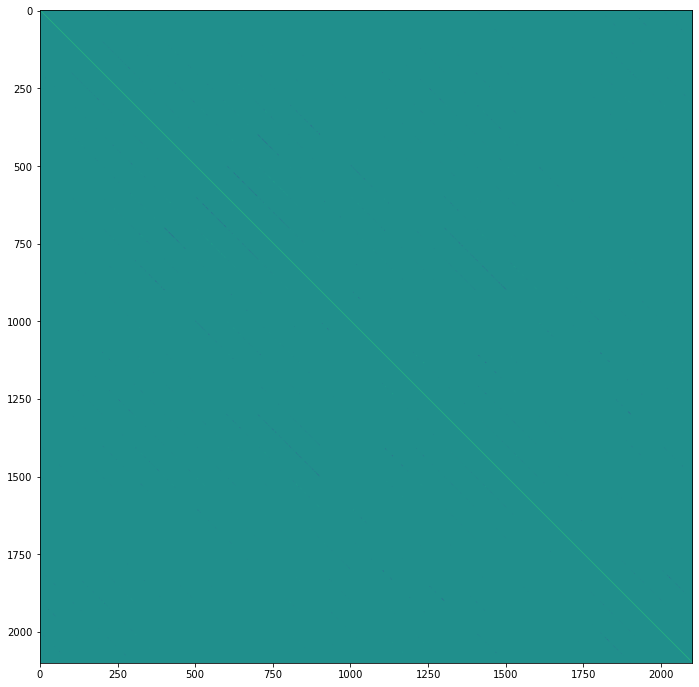

In [ ]:
plt.figure(figsize=(12,12))

plt.imshow(exp.reg.get_correlation())

In [ ]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

/net/dsvr-01/home/rmaiwald/code/BayesInverse/bayesinverse/regression.py:496: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(


(inf, 866.8677530720804, 1233.1322469279196)

In [ ]:
-0.5 * np.log(np.abs(np.linalg.det(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())))

/tmp/ipykernel_1075875/2513801941.py:1: RuntimeWarning: divide by zero encountered in log
  -0.5 * np.log(np.abs(np.linalg.det(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())))


inf

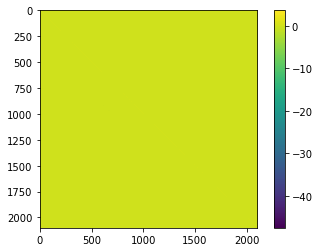

In [ ]:
im = plt.imshow(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())
plt.colorbar(im)